# Onsets

In [1]:
import logging
# logging.getLogger('maelzel').setLevel('DEBUG')
from maelzel.snd import features
from maelzel.snd import plotting, audiosample
import numpy as np
from maelzel.core import *
from pitchtools import *
import matplotlib.pyplot as plt

import csoundengine as ce

end of score.		   overall amps:      0.0
	   overall samples out of range:        0
0 errors in performance


In [2]:
samp = audiosample.Sample("snd/finneganswake-fragm01.flac").getChannel(0, contiguous=True)[0:10]

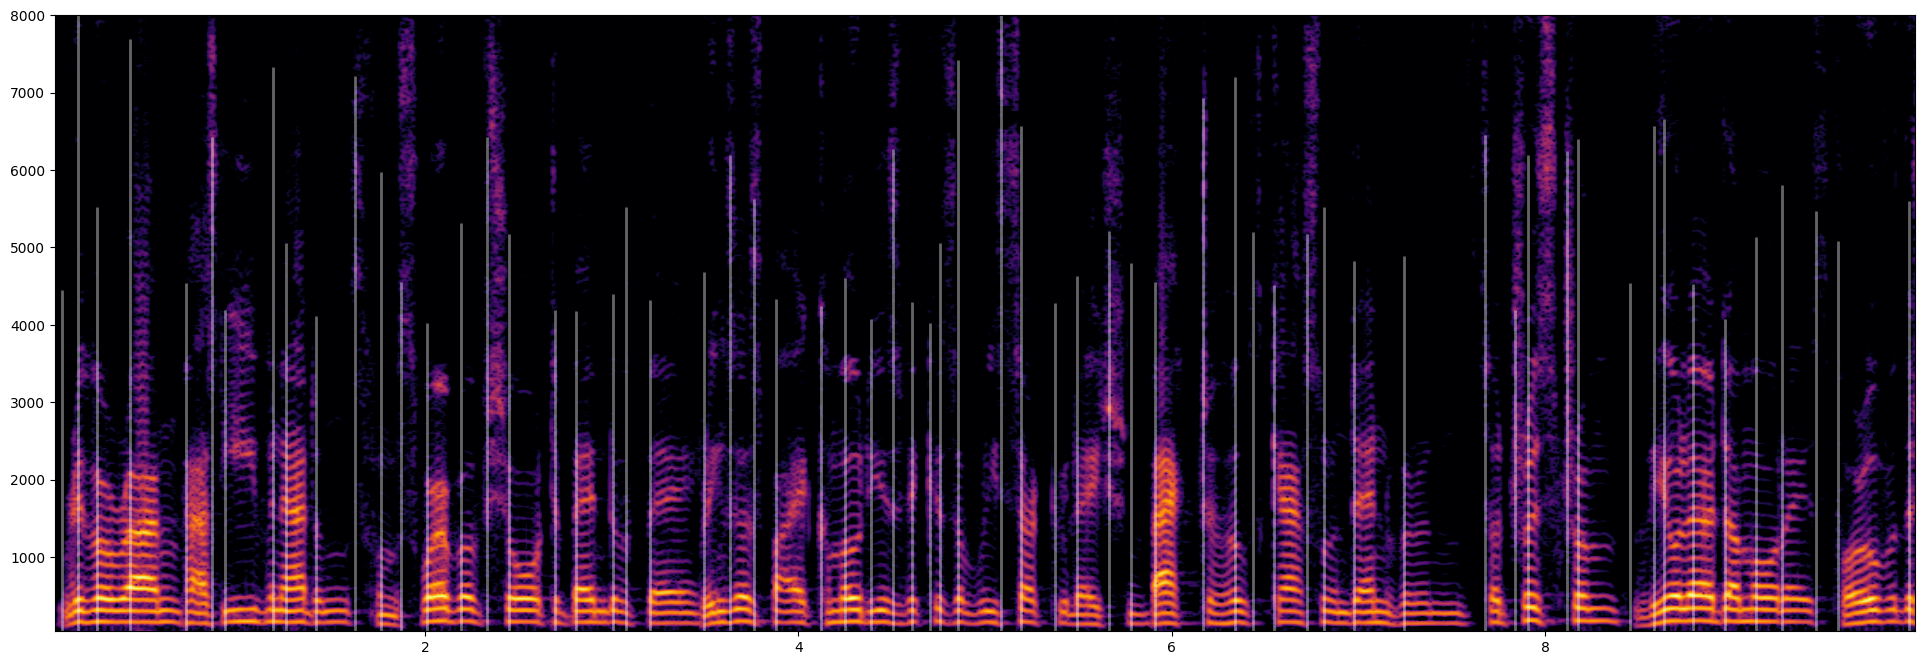

In [3]:
onsets, onsetStrength = features.onsets(samp.samples, sr=samp.sr, threshold=0.1, mingap=1/20, winsize=2048, hopsize=512)

ax = plotting.plotSpectrogram(samp.samples, sr=samp.sr, maxfreq=8000)

# Plot each onset as a vertical line
ymax = 4000 + onsetStrength.map(onsets)*2000
ax.vlines(onsets, ymin=0, ymax=ymax, color='white', alpha=0.4, linewidth=2)


In [4]:
from maelzel.snd import freqestimate
freqbpf, voicedbpf = freqestimate.f0curvePyinVamp(sig=samp.samples, sr=samp.sr,  
                                                  onsetSensitivity=0.1, pruneThreshold=0.1, threshDistr='beta30', fftsize=2048, overlap=8)

LibXtract compiled with ooura FFT


mnOut size: 1723
m_pitchTrack size: 1723


(0.0, 8.0)

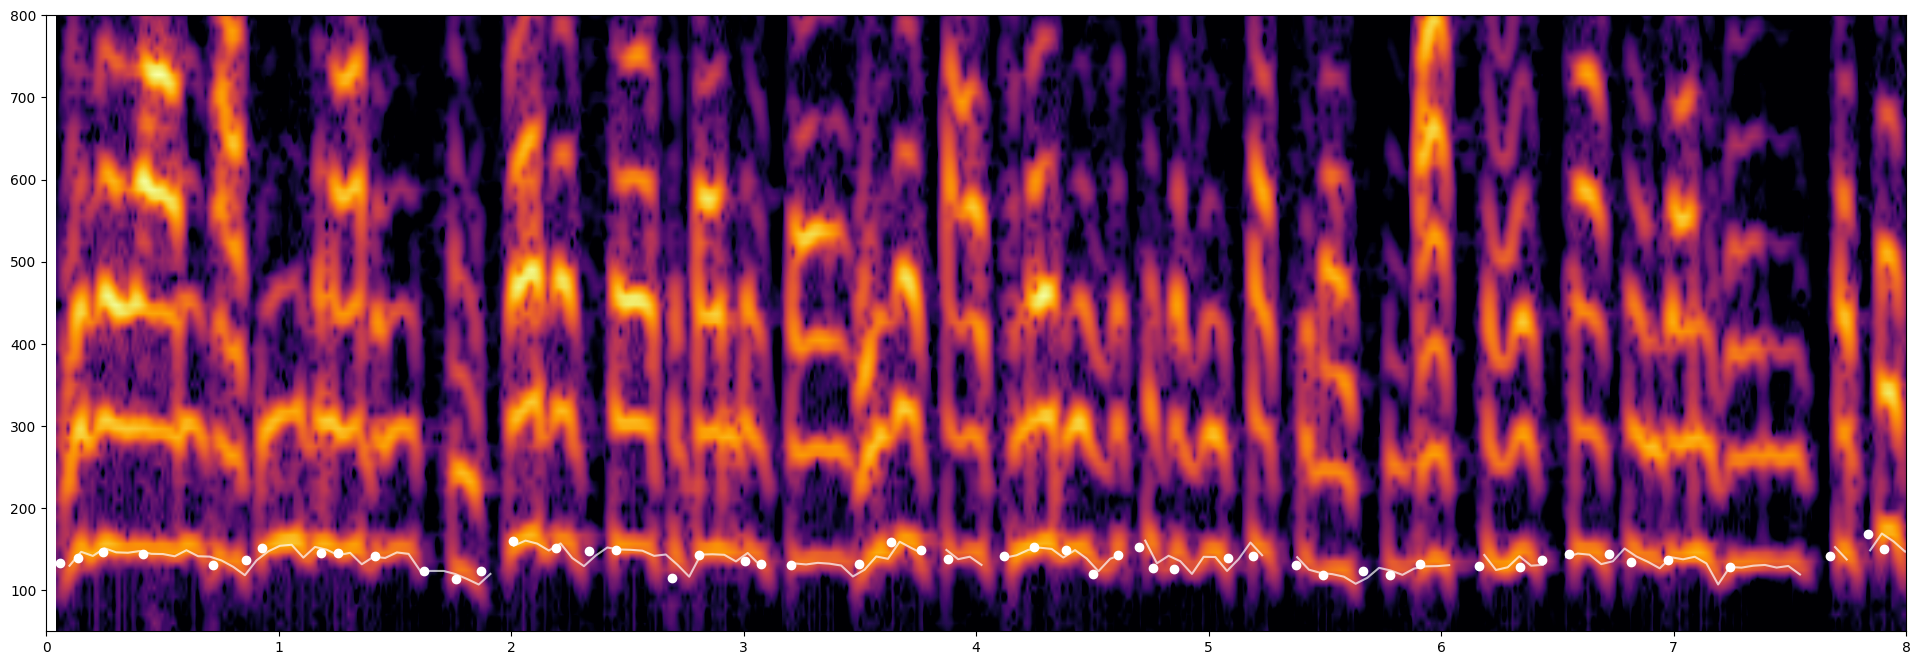

In [5]:
ampcurve = samp.peaksbpf(framedur=0.01, overlap=4)
amps = ampcurve.map(onsets)
freqs = freqbpf.map(onsets+0.05)

ax = plotting.plotSpectrogram(samp.samples, sr=samp.sr, fftsize=4092, overlap=8, maxfreq=800, minfreq=50, )
(freqbpf * (ampcurve > 0.01).nanmask()).plot(axes=ax, color=(1, 1, 1, 0.7), show=False)
ax.scatter(onsets, freqs, color=(1, 1, 1), zorder=3)
ax.set_xlim(0, 8)

Chain([3C+30:-20dB:0.081♩, 3Db-06:-4dB:0.104♩, 3D-16:-3dB:0.174♩, 3D-35:-1dB:0.302♩, 3C-01:-7dB:0.139♩, 3Db-33:-11dB:0.07♩, 3Eb-49:-8dB:0.255♩, 3D-23:-6dB:0.07♩, 3D-28:-4dB:0.163♩, 3C#+24:-7dB:0.209♩, …])
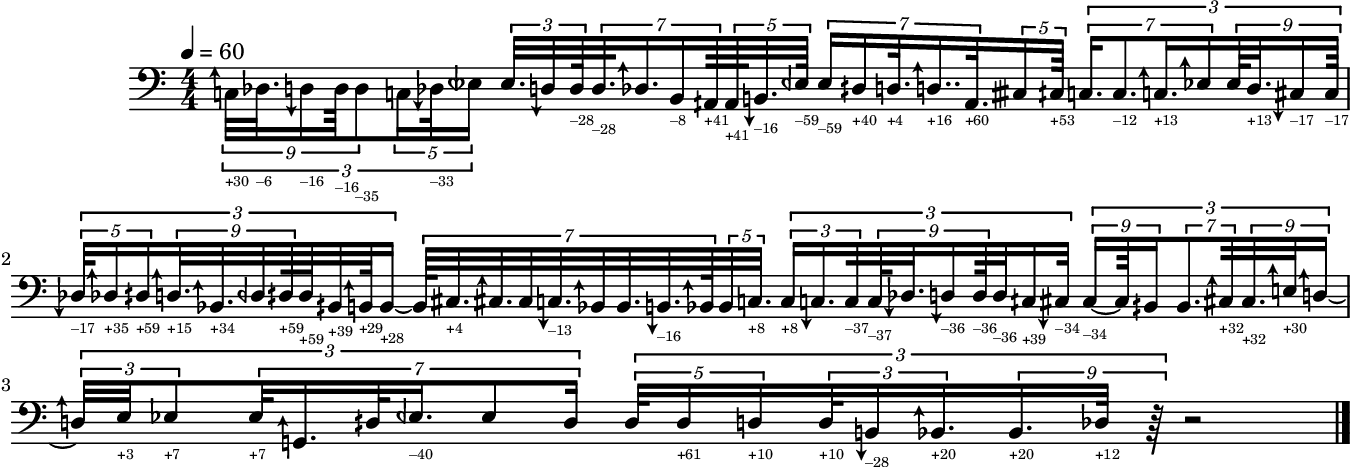

In [10]:
durs = np.empty_like(onsets)
durs[:-1] = onsets[1:] - onsets[:-1]
durs[-1] = durs[0]

notes = []
minamp = db2amp(-25)
lastfreq = next(f for f in freqs if not np.isnan(f))
for freq, dur, amp in zip(freqs, durs, amps):
    if np.isnan(freq):
        note = Note(f2m(lastfreq), dur=dur, amp=amp, label='k') if amp > minamp else Rest(dur=dur)
        notes.append(note)
    else:
        notes.append(Note(f2m(freq), dur=dur, amp=amp**0.5))
        lastfreq = freq
voice = Chain(notes)
voice

## Sync playback

`play` can be used to synthesize events ensuring synchronicity between these events and any other sound played through the audio engine itself. Within `play` all setup operations and scheduling is handled as to ensure that events scheduled to sound simultaneous are indeed played in sync even when playing a large number of notes and automation with multiple setup operations (reading tables, loading soundfonts, etc)

The most common way to use `play` is as a context manager: 

In [7]:
with play():
    voice.play(gain=2, instr='.piano', fade=(0, 0.5))
    getSession().playSample((samp.samples, samp.sr), pan=1)




--Csound version 6.19 (double samples) May  8 2024
[commit: 937aa495e250d758efaa28e9697a8b75237c80cd]
libsndfile-1.2.0
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 442.0
audio buffered in 256 sample-frame blocks
reading 2048-byte blks of shorts from adc:Built-in Audio Analog Stereo: (RAW)
writing 512 sample blks of 64-bit floats to dac:Built-in Audio Analog Stereo:
SECTION 1:


The same effect can be achieved by passing the `.event`s to play as arguments:

In [85]:
play(
    voice.synthEvents(gain=2, instr='.piano', fade=(0, 0.5)),
    getSession().makeSampleEvent((samp.samples, samp.sr), pan=1)
)

Button(description='Stop', style=ButtonStyle())

Output()

SynthGroup(n=65)
    Synth(𝍪 preset:.piano=501.0066 start=14.931 dur=0.081 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.0812698 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=48.3006 p19=0.0953637 …)
    Synth(𝍪 preset:.piano=501.0067 start=15.013 dur=0.104 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.10449 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=48.9373 p19=0.659682 …)
    Synth(𝍪 preset:.piano=501.0068 start=15.117 dur=0.174 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.17415 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=49.8352 p19=0.746473 …)
    Synth(𝍪 preset:.piano=501.0069 start=15.291 dur=0.302 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.301859 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=49.6489 p19=0.845051 …)
    Synth(𝍪 preset:.piano=501.007 start=15.593 dur=0.139 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.13932 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=47.9851 p19=0.451235 …)
    Synth(𝍪 preset:.piano=501.0071 start=15.732 dur=0.070 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.0696599 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=48.6738 p19=0.27114 …)
    Synth(𝍪 preset:.piano=501.0072 start=15.802 dur=0.255 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.25542 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=50.5064 p19=0.387093 …)
    Synth(𝍪 preset:.piano=501.0073 start=16.058 dur=0.070 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.0696599 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=49.7664 p19=0.481404 …)
    Synth(𝍪 preset:.piano=501.0074 start=16.127 dur=0.163 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.16254 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=49.7171 p19=0.668209 …)
    Synth(𝍪 preset:.piano=501.0075 start=16.290 dur=0.209 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.20898 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=49.2431 p19=0.422248 …)
    Synth(𝍪 preset:.piano=501.0076 start=16.499 dur=0.139 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.13932 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=46.9214 p19=0.136572 …)
    Synth(𝍪 preset:.piano=501.0077 start=16.638 dur=0.104 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.10449 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=45.4085 p19=0.368482 …)
    Synth(𝍪 preset:.piano=501.0078 start=16.742 dur=0.139 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.13932 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=46.8443 p19=0.188393 …)
    Synth(𝍪 preset:.piano=501.0079 start=16.882 dur=0.186 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.18576 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=51.4114 p19=0.649246 …)
    Synth(𝍪 preset:.piano=501.008 start=17.068 dur=0.139 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.13932 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=50.4002 p19=0.552427 …)
    Synth(𝍪 preset:.piano=501.0081 start=17.207 dur=0.116 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.1161 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=50.0443 p19=0.207436 …)
    Synth(𝍪 preset:.piano=501.0082 start=17.323 dur=0.244 p4=0.5 kpos=2 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0 ifadein=0.24381 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=50.1638 p19=0.521393 …)
    Synth(𝍪 preset:.piano=501.0083 

## Absolute time / Symbolic time

The same score can be notated in any tempo without affecting its absolute time. **For that is is necessary to set the starting point and duration of the notes according to a new tempo**, remapping one score structure to another. Thus, the notation reflects the new score structure but playback is unaffected. **Notice that the new tempo and time signature result in a completely different quantization**

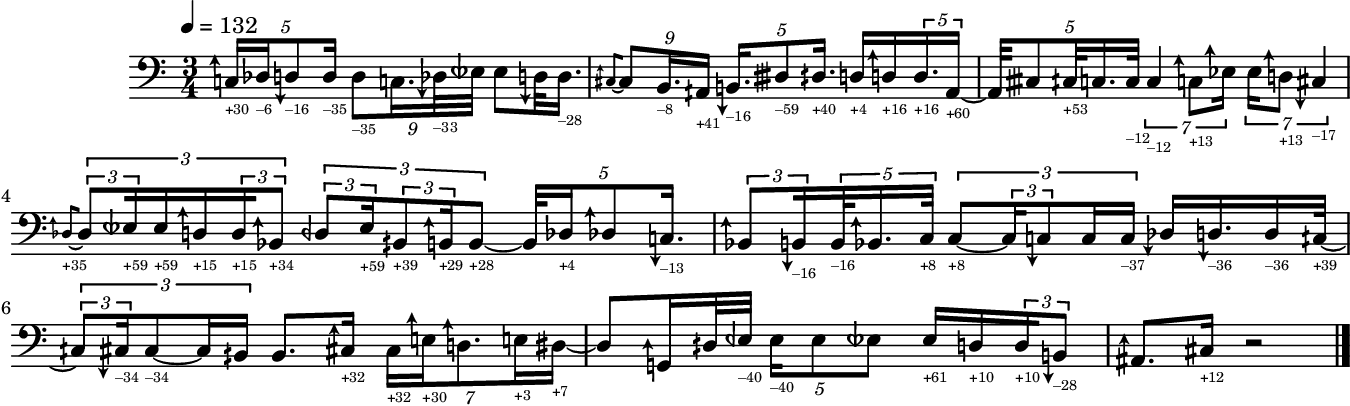

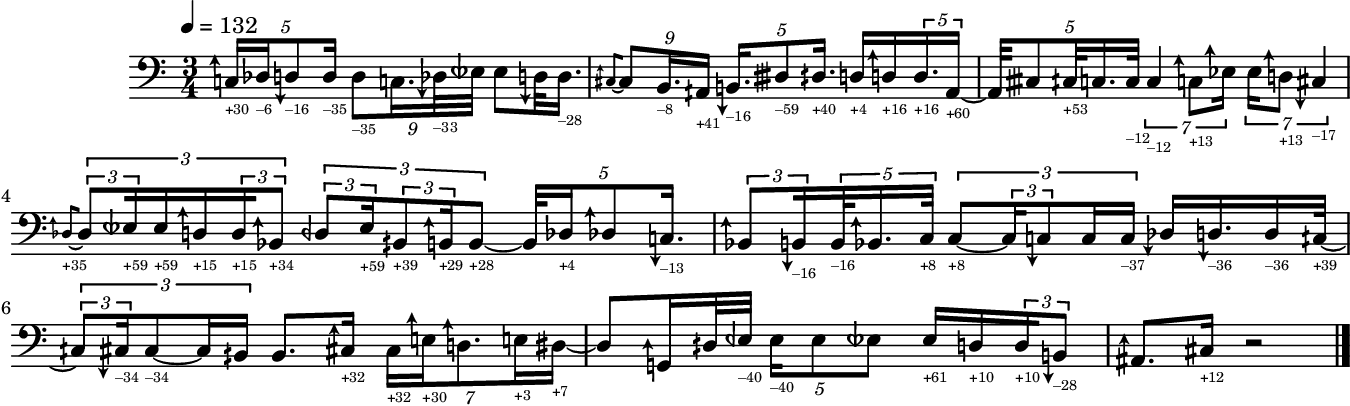

In [12]:
# Ensure that each note has an explicit offset. This makes computation easier
# by setting .offset and .end to explicit values
# voice.stack()

newstruct = ScoreStruct(tempo=132, timesig=(3,4))

sco = Score([voice]).remap(newstruct)
sco.show()

# This is the same as:

voice2 = voice.remap(newstruct)
with newstruct, play() as s:
    voice2.show()
    voice2.play(gain=2, instr='.piano', fade=(0, 0.5))
    s.session.playSample((samp.samples, samp.sr), pan=1)

Another version of the transcription, this time with a slower tempo and a *7/16* time signature, played with long sustain, as if the piano pedal was held down

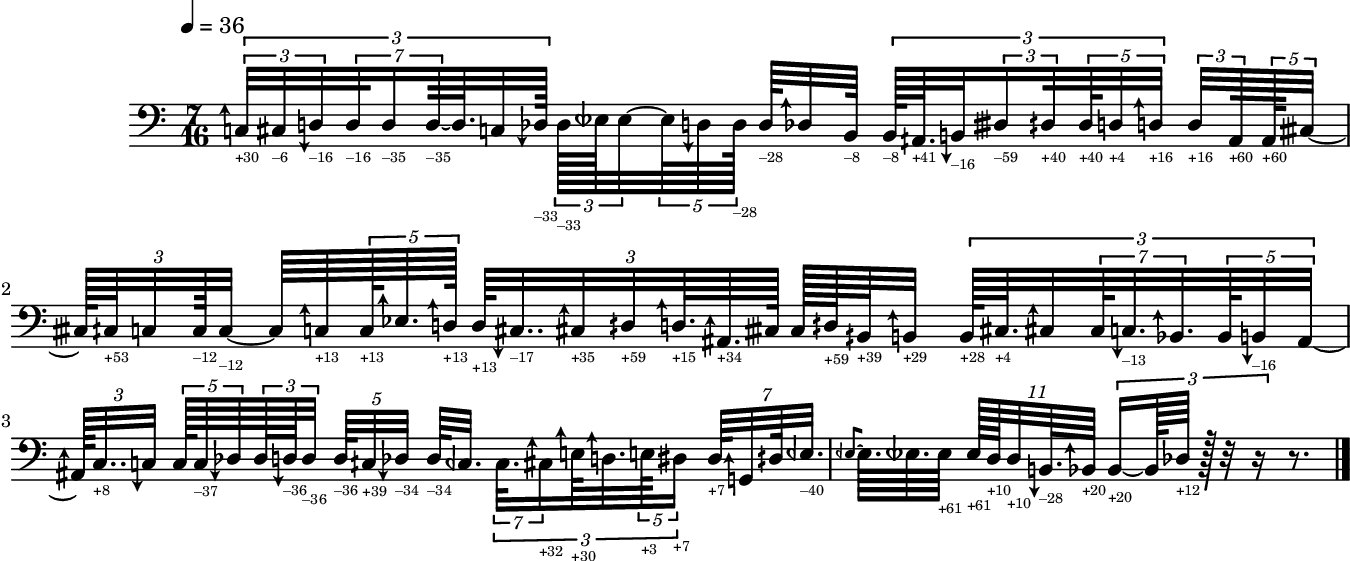

In [45]:
newstruct = ScoreStruct(tempo=36, timesig=(7, 16))
voice3 = voice.remap(newstruct)
with newstruct, play() as s:
    voice3.show()
    voice3.play(gain=2, instr='.piano', fade=(0, 3), sustain=8)
    s.session.playSample((samp.samples, samp.sr), pan=1)

In [46]:
voice4 = voice.quantizePitch(step=0.5)

with play() as s:
    voice4.play(gain=1.5, position=0)
    s.session.playSample((samp.samples, samp.sr), pan=1)
    

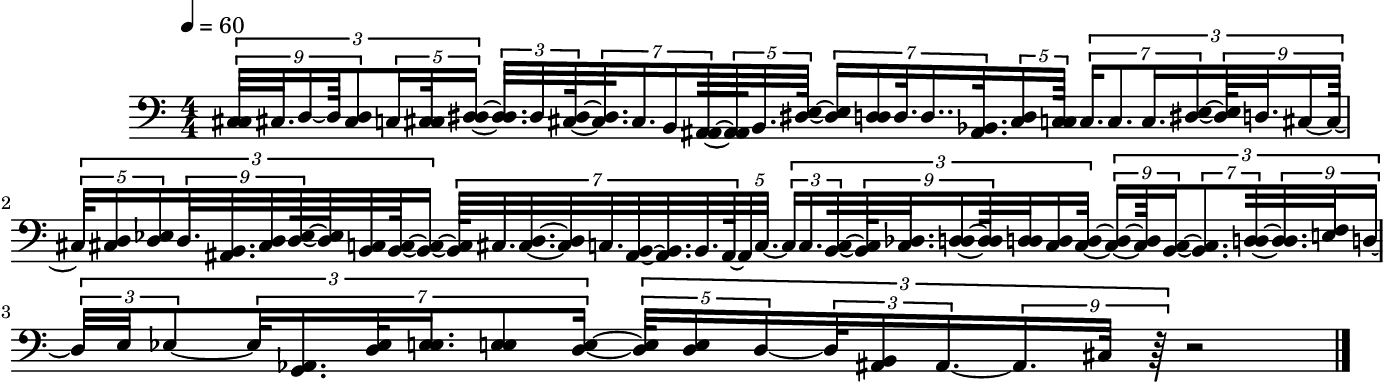

In [47]:
events = []
for event in voice4.flatEvents():
    if event.pitch > int(event.pitch):
        low = int(event.pitch)
        event = Chord(notes=[low, low+1], dur=event.dur, amp=event.amp)
    events.append(event)
        
voice5 = voice4.clone(items=events)
voice5.show()

In [48]:
voice5.play()

Button(description='Stop', style=ButtonStyle())

Output()

SynthGroup(n=101)
    Synth(𝍪 preset:.piano=501.1275 start=6061.699 dur=0.081 p4=0.5 kpos=0.707107 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=48 p19=0.0953637 …)
    Synth(𝍪 preset:.piano=501.1276 start=6061.699 dur=0.081 p4=0.5 kpos=0.707107 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=49 p19=0.0953637 …)
    Synth(𝍪 preset:.piano=501.1277 start=6061.781 dur=0.104 p4=0.5 kpos=1 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=49 p19=0.659682 …)
    Synth(𝍪 preset:.piano=501.1278 start=6061.885 dur=0.174 p4=0.5 kpos=1 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=50 p19=0.746473 …)
    Synth(𝍪 preset:.piano=501.1279 start=6062.059 dur=0.302 p4=0.5 kpos=0.707107 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=49 p19=0.845051 …)
    Synth(𝍪 preset:.piano=501.128 start=6062.059 dur=0.302 p4=0.5 kpos=0.707107 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=50 p19=0.845051 …)
    Synth(𝍪 preset:.piano=501.1281 start=6062.361 dur=0.139 p4=0.5 kpos=1 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=48 p19=0.451235 …)
    Synth(𝍪 preset:.piano=501.1282 start=6062.500 dur=0.070 p4=0.5 kpos=0.707107 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=48 p19=0.27114 …)
    Synth(𝍪 preset:.piano=501.1283 start=6062.500 dur=0.070 p4=0.5 kpos=0.707107 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=49 p19=0.27114 …)
    Synth(𝍪 preset:.piano=501.1284 start=6062.570 dur=0.255 p4=0.5 kpos=0.707107 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=50 p19=0.387093 …)
    Synth(𝍪 preset:.piano=501.1285 start=6062.570 dur=0.255 p4=0.5 kpos=0.707107 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=51 p19=0.387093 …)
    Synth(𝍪 preset:.piano=501.1286 start=6062.826 dur=0.070 p4=0.5 kpos=1 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=50 p19=0.481404 …)
    Synth(𝍪 preset:.piano=501.1287 start=6062.895 dur=0.163 p4=0.5 kpos=0.707107 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=49 p19=0.668209 …)
    Synth(𝍪 preset:.piano=501.1288 start=6062.895 dur=0.163 p4=0.5 kpos=0.707107 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=50 p19=0.668209 …)
    Synth(𝍪 preset:.piano=501.1289 start=6063.058 dur=0.209 p4=0.5 kpos=1 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=49 p19=0.422248 …)
    Synth(𝍪 preset:.piano=501.129 start=6063.267 dur=0.139 p4=0.5 kpos=1 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=47 p19=0.136572 …)
    Synth(𝍪 preset:.piano=501.1291 start=6063.406 dur=0.104 p4=0.5 kpos=0.707107 kgain=18 idataidx_=2 inumbps=3 ibplen=1 ichan=0.02 ifadein=0.02 ifadeout=0 ipchintrp_=1 ifadekind=0 ktransp=0.1 ipitchlag=-1 ivel=0 p18=45 p19=0.368482 …)
    Synth(𝍪 pr